In [1]:
# !pip install mapbox-vector-tile pmtiles geopandas shapely trimesh python-snappy flatbuffers matplotlib

In [2]:
# %cd ./pmtiles_python
# !pip install -e .
# %cd ..

In [3]:
# !wget https://github.com/protomaps/go-pmtiles/releases/download/v1.10.5/go-pmtiles_1.10.5_Linux_x86_64.tar.gz
# !tar -xvzf go-pmtiles_1.10.5_Linux_x86_64.tar.gz

In [4]:
# !wget https://build.protomaps.com/20231023.pmtiles

In [5]:
# !./pmtiles extract https://build.protomaps.com/20231118.pmtiles shanghai.pmtiles --bbox=121.3,31,121.6,31.7

In [6]:
import json
import gzip
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import snappy

from shapely.geometry import shape
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon

from pmtiles.tile import zxy_to_tileid, tileid_to_zxy, TileType, Compression, deserialize_directory
from pmtiles.writer import Writer, write
from pmtiles.reader import Reader, MmapSource, all_tiles

import mapbox_vector_tile as mvt
import flatbuffers

from vector_tile import Layer, Feature, Tile, Value
from vector_tile.TagType import TagType
from vector_tile.GeomType import GeomType

In [7]:
# with open("/content/shanghai-20231024-mini.pmtiles", "r+b") as f:
#     source = MmapSource(f)

# reader = Reader(source)
# header = reader.header()
# dir_offset = header["root_offset"]
# dir_length = header["root_length"]
# print(dir_offset, dir_length)
# directory = deserialize_directory(reader.get_bytes(dir_offset, dir_length))

# print(len(directory))
# for i, entry in enumerate(directory):
#     print(entry.tile_id)
#     if i > 10: break

In [8]:
def read_metadata(source):
    reader = Reader(source)
    header = reader.header()
    metadata = reader.metadata()

    if "minzoom" not in metadata:
        metadata["minzoom"] = header["min_zoom"]

    if "maxzoom" not in metadata:
        metadata["maxzoom"] = header["max_zoom"]

    if "bounds" not in metadata:
        min_lon = header["min_lon_e7"] / 10000000
        min_lat = header["min_lat_e7"] / 10000000
        max_lon = header["max_lon_e7"] / 10000000
        max_lat = header["max_lat_e7"] / 10000000
        metadata["bounds"] = f"{min_lon},{min_lat},{max_lon},{max_lat}"

    if "center" not in metadata:
        center_lon = header["center_lon_e7"] / 10000000
        center_lat = header["center_lat_e7"] / 10000000
        center_zoom = header["center_zoom"]
        metadata["center"] = f"{center_lon},{center_lat},{center_zoom}"

    if "format" not in metadata:
        if header["tile_type"] == TileType.MVT:
            metadata["format"] = "pbf"

    return header, metadata


def read_tiles(source):
    for zxy, tile_data in tqdm(all_tiles(source)):
        [z, x, y] = zxy
        tileid = zxy_to_tileid(z, x, y)

        yield zxy, tileid, tile_data


def modify_tiles(input, output, mod_func=None, tile_compression=Compression.GZIP):
    with open(input, "r+b") as f:
        source = MmapSource(f)
        header, metadata = read_metadata(source)

        with write(output) as writer:
            for zxy, tileid, tile_data in read_tiles(source):
                if mod_func:
                    tile_data = mod_func(zxy, tileid, tile_data)
                if tile_data is not None:
                    writer.write_tile(tileid, tile_data)

            header["tile_compression"] = tile_compression

            writer.finalize(header, metadata)

In [9]:
# modify_tiles("shanghai.pmtiles", "shanghai-mini.pmtiles", None)

In [10]:
import mapbox_vector_tile
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import MultiLineString, LineString
from shapely.ops import linemerge, polygonize
import matplotlib.pyplot as plt

2


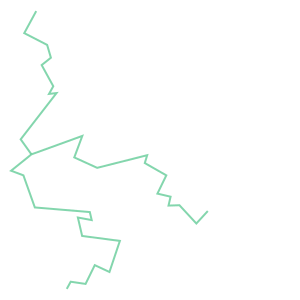

In [11]:
from shapely.geometry import MultiLineString
from shapely.ops import linemerge, unary_union


def greedy_merge_lines(lines):
    """
    Greedily merge lines by iteratively merging each line with as many other lines as possible.

    Parameters:
    lines (list): A list of LineString objects

    Returns:
    list: A list of merged LineString objects
    """
    merged = []
    while lines:
        current = lines.pop(0)
        merged_with_current = False

        for i, other in enumerate(lines):
            merge_attempt = linemerge([current, other])
            # Check if current line can be merged with other
            if current.touches(other) and merge_attempt.geom_type == 'LineString':
                current = merge_attempt
                lines.pop(i)  # Remove the merged line
                merged_with_current = True

        merged.append(current)

    return merged


def apply_greedy_merge(multilinestring):
    """
    Apply the greedy merging strategy to a MultiLineString.

    Parameters:
    multilinestring (MultiLineString): A shapely MultiLineString object

    Returns:
    MultiLineString: Merged LineString(s)
    """
    lines = list(multilinestring.geoms)
    merged_lines = greedy_merge_lines(lines)

    return MultiLineString(merged_lines)


# Testing if linemerge can merge two lines sharing a common endpoint
multi_line = MultiLineString([[(499.0, 3321.0), (797.0, 3429.0), (750.0, 3303.0), (884.0, 3242.0), (1177.0, 3316.0), (1163.0, 3270.0), (1289.0, 3198.0), (1237.0, 3091.0), (1314.0, 3073.0), (1302.0, 3021.0), (1366.0, 3023.0), (1465.0, 2916.0), (1532.0, 2989.0)],
                              [(499.0, 3321.0), (380.0, 3225.0), (452.0, 3198.0), (519.0, 3010.0), (841.0, 2983.0), (852.0, 2936.0), (771.0, 2951.0), (
                                  796.0, 2843.0), (1017.0, 2814.0), (956.0, 2632.0), (870.0, 2672.0), (816.0, 2562.0), (729.0, 2575.0), (706.0, 2533.0)],
                              [(499.0, 3321.0), (436.0, 3409.0), (646.0, 3680.0), (602.0, 3675.0), (627.0, 3720.0), (559.0, 3844.0), (613.0, 3887.0), (591.0, 3962.0), (457.0, 4031.0), (527.0, 4160.0)]])

merged = apply_greedy_merge(multi_line)

print(len(merged.geoms))
merged

In [12]:
def simplify_geom(geom, tolerance=8):
    if isinstance(geom, MultiLineString):
        # print("Merging multistring, original: ", len(geom.geoms))
        geom = apply_greedy_merge(geom)
        # print("Merged: ", len(geom.geoms))

    geom = geom.simplify(tolerance=tolerance, preserve_topology=True)
    return geom

In [13]:
import random
import math


def deg2num(lat_deg, lon_deg, zoom):
    """Convert latitude and longitude to tile numbers at a specific zoom level."""
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    return (xtile, ytile)


def random_tile_name(z, bbox=None):
    """
    Generate a random vector tile name given a zoom level and an optional bounding box.

    Parameters:
    - z: Zoom level.
    - bbox: Optional bounding box as a tuple (min_lon, min_lat, max_lon, max_lat).

    Returns:
    - Tuple (z, x, y) representing the random tile name.
    """

    if bbox:
        min_lon, min_lat, max_lon, max_lat = bbox

        # Convert the bounding box's corners to tile coordinates
        min_x, max_y = deg2num(min_lat, min_lon, z)
        max_x, min_y = deg2num(max_lat, max_lon, z)

        # Randomly select x and y within the bounding box's range
        x = random.randint(min_x, max_x)
        y = random.randint(min_y, max_y)
    else:
        # If no bounding box is given, use the entire range of tiles for the zoom level
        max_value = 2**z - 1
        x = random.randint(0, max_value)
        y = random.randint(0, max_value)

    return (z, x, y)

# Example usage with bounding box:
# bbox = (-123.7, 37.4, -121.8, 38.5)  # Bounding box around the San Francisco Bay Area
# z = 10
# print(random_tile_name(z, bbox))

# Example usage without bounding box:
# z = 10
# print(random_tile_name(z))

In [14]:
import trimesh
from shapely.geometry import Polygon, LineString


def approximate_width_of_river(polygon, resolution=None, clip=None):
    """
    Approximate the width of a river represented as a Polygon using trimesh for medial axis computation.

    Parameters:
    - polygon: The input Polygon representing the river.
    - resolution: Distance between each sample on the polygon boundary for trimesh medial axis computation.
    - clip: Clip sample count for trimesh medial axis computation.

    Returns:
    - Approximate width of the river.
    """

    # Ensure input is a polygon
    if not isinstance(polygon, Polygon):
        raise ValueError("Input must be a Polygon")

    # Calculate the medial axis using trimesh
    edges, vertices = trimesh.path.polygons.medial_axis(
        polygon, resolution=resolution, clip=clip)

    # Convert edges and vertices to Shapely LineStrings
    lines = [LineString([vertices[i], vertices[j]]) for i, j in edges]

    # Calculate total length of the medial axis segments
    total_length = sum(line.length for line in lines)

    # Approximate the width
    width = polygon.area / total_length

    print(width)

    return width

# Example usage:
# river_polygon = Polygon(...)
# width = approximate_width_of_river(river_polygon)
# print(width)

In [15]:
from shapely.geometry import MultiPolygon


def filter_small_areas(geom, min_area):
    """
    Filters out polygons with an area smaller than min_area from a given geometry.

    Parameters:
    - geom: The input geometry. Can be a Polygon or MultiPolygon.
    - min_area: The minimum area threshold.

    Returns:
    - A filtered Polygon or MultiPolygon.
    """

    # Ensure the geometry is a MultiPolygon for consistent processing
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])

    # Filter out small polygons
    filtered_polys = [
        polygon for polygon in geom.geoms if polygon.area >= min_area]

    # Return as a Polygon or MultiPolygon depending on the number of polygons left
    if len(filtered_polys) == 1:
        return filtered_polys[0]
    elif filtered_polys:
        return MultiPolygon(filtered_polys)
    else:
        return None  # or whatever is appropriate when all polygons are filtered out

# Example usage:
# geom = some MultiPolygon or Polygon geometry
# min_area = 10000  # or whatever threshold you want
# result = filter_small_areas(geom, min_area)

In [16]:
from shapely.geometry import MultiPolygon


def filter_thin_rivers(geom, min_width):
    """
    Filters out polygons with an area smaller than min_area from a given geometry.

    Parameters:
    - geom: The input geometry. Can be a Polygon or MultiPolygon.
    - min_width: The minimum width threshold.

    Returns:
    - A filtered Polygon or MultiPolygon.
    """

    # Ensure the geometry is a MultiPolygon for consistent processing
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])

    # Filter out small polygons
    filtered_polys = [
        polygon for polygon in geom.geoms if polygon.area / (polygon.length / 2) >= min_width]

    # Return as a Polygon or MultiPolygon depending on the number of polygons left
    if len(filtered_polys) == 1:
        return filtered_polys[0]
    elif filtered_polys:
        return MultiPolygon(filtered_polys)
    else:
        return None  # or whatever is appropriate when all polygons are filtered out

# Example usage:
# geom = some MultiPolygon or Polygon geometry
# min_area = 10000  # or whatever threshold you want
# result = filter_small_areas(geom, min_area)

In [17]:
from shapely.geometry import Point, MultiPoint


def is_inside_tile(geometry):
    """
    Check if a Point or MultiPoint feature with coordinates ranging from (0, 0) to (4096, 4096) is inside the current tile.

    Parameters:
    - geometry: A shapely Point or MultiPoint object.

    Returns:
    - Boolean: True if the geometry is inside the tile, False otherwise.
    """

    # Define the bounds of the tile
    TILE_MIN = 0
    TILE_MAX = 4096

    if isinstance(geometry, Point):
        # Check if a single point is within bounds
        return TILE_MIN <= geometry.x <= TILE_MAX and TILE_MIN <= geometry.y <= TILE_MAX

    elif isinstance(geometry, MultiPoint):
        # Check if all points in the multipoint are within bounds
        for point in geometry.geoms:
            if not (TILE_MIN <= point.x <= TILE_MAX and TILE_MIN <= point.y <= TILE_MAX):
                return False
        return True

    else:
        raise ValueError("Input geometry must be a Point or MultiPoint")

# Example usage:
# point = Point(2000, 3000)
# print(is_inside_tile(point))  # This should return True

# multipoint = MultiPoint([(2000, 3000), (4000, 5000)])
# print(is_inside_tile(multipoint))  # This should return False because the second point is outside the tile

In [18]:
def filter_feature(feature, geom, layer_name, zoom):
    """
    Filter the features based on layer name and zoom level.

    Parameters:
    - feature: The feature to be checked.
    - layer_name: The name of the layer.
    - zoom: The zoom level.

    Returns:
    - bool: True if the feature should be preserved, otherwise False.
    """

    props = feature["properties"]

    if layer_name == "boundaries":
        if props.get("pmap:min_admin_level") == 6:
            if 10 > zoom:
                return simplify_geom(geom, 32)
            elif 12 > zoom >= 10:
                return simplify_geom(geom, 24)
            elif 14 > zoom >= 12:
                return simplify_geom(geom, 16)
            else:
                return False

        if props.get("pmap:min_admin_level") > 6:
            if 14 > zoom >= 12:
                return simplify_geom(geom, 16)
            else:
                return False

    elif layer_name == "buildings":
        if zoom >= 15:
            if geom.area > 2000:
                return simplify_geom(geom, 16)

    elif layer_name == "landuse":
        return False

    elif layer_name == "natural":
        return False

    elif layer_name == "physical_line":
        return False

    elif layer_name == "physical_point":
        return False

    elif layer_name == "places":
        if not is_inside_tile(geom):
            return False

        if 11 > zoom:
            if props.get("pmap:kind") == "region":
                return geom
        if 13 > zoom >= 11:
            if props.get("pmap:kind") in ["region", "locality"] and props.get("pmap:min_zoom", 26) <= 8:
                return geom
        if zoom >= 13:
            return geom

    elif layer_name == "pois":
        if zoom >= 15:
            if is_inside_tile(geom) and "name" in props:
                return geom

    elif layer_name == "roads":
        if props.get("pmap:kind") == "minor_road":
            if zoom >= 15:
                return simplify_geom(geom, 4)
        if props.get("pmap:kind") == "medium_road":
            if zoom >= 14:
                return simplify_geom(geom, 8)
        if props.get("pmap:kind") == "major_road":
            if zoom >= 13:
                return simplify_geom(geom, 16)

    elif layer_name == "transit":
        if props.get("pmap:kind") == "subway" or props.get("route") == "ferry":
            if zoom >= 14:
                return simplify_geom(geom, 8)

    elif layer_name == "water":
        if zoom >= 12:
            return simplify_geom(geom, 4)

        elif 12 > zoom >= 11:
            geom = filter_thin_rivers(geom, 20)
            if geom is not None:
                return simplify_geom(geom, 6)

        elif 11 > zoom >= 7:
            if geom is not None:
                return simplify_geom(geom, 8)

        elif 7 > zoom >= 4:
            return simplify_geom(geom, 16)

        elif 4 > zoom:
            return simplify_geom(geom, 32)

    return False

In [19]:
def filter_properties(feature):

    keep = ["name", "name:en", "pmap:kind", "pmap:min_zoom"]

    feature["properties"] = {p: v for p, v in feature["properties"].items()
                             if p in keep}

In [20]:
def minify_decoded_mvt(decoded_data, zoom):
    layers = []

    for layer_name, layer in decoded_data.items():

        features = []

        for feature in layer["features"]:

            geom = shape(feature['geometry'])
            geom = filter_feature(feature, geom, layer_name, zoom)

            if geom:
                feature["geometry"] = geom
                filter_properties(feature)
                features.append(feature)
        
        if layer_name == "buildings":
            limit = 5
            # Limit number of buildings
            features = sorted(features, key=lambda x: x["geometry"].area, reverse=True)[:limit]

        layers.append({"name": layer_name, "features": features})

    return layers

14 13718 6679
417


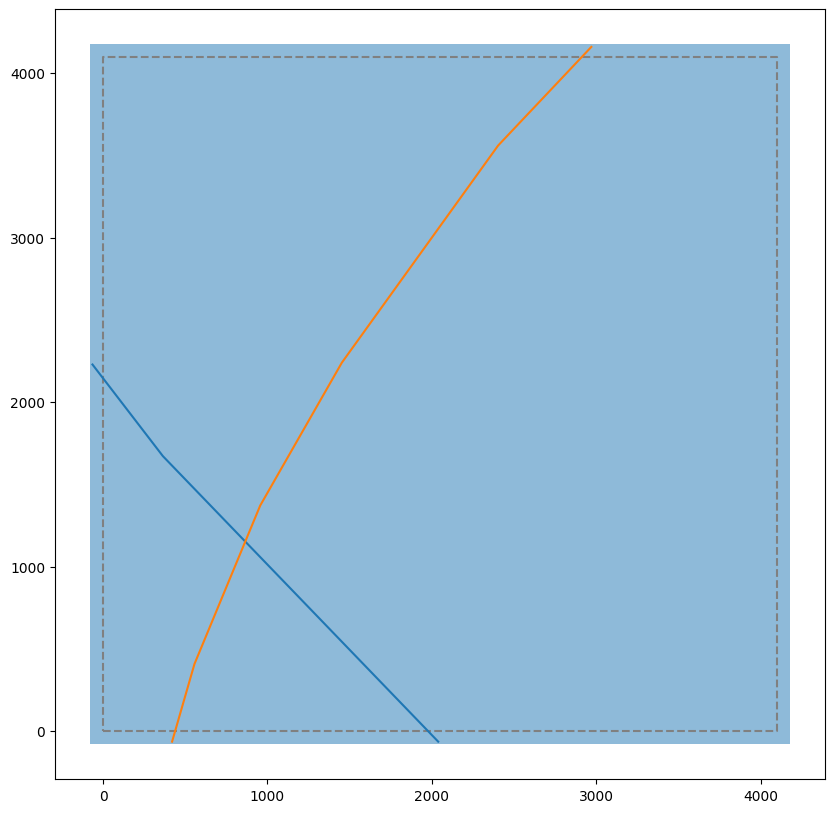

310
308


In [21]:
def display_decoded_mvt_with_matplotlib(decoded_data, zoom, figsize=(10, 10)):
    """
    Display pre-decoded MVT data using matplotlib directly.

    Parameters:
    - decoded_data: Pre-decoded MVT data.
    """

    fig, ax = plt.subplots(figsize=figsize)

    ax.plot([0, 4096, 4096, 0, 0], [0, 0, 4096, 4096, 0],
            color="grey", linestyle="--")

    for layer in decoded_data:
        layer_name = layer["name"]

        for feature in layer["features"]:

            geom = shape(feature['geometry'])

            if geom.geom_type == 'Polygon':
                x, y = geom.exterior.xy
                ax.fill(x, y, alpha=0.5)
                for interior in geom.interiors:
                    x, y = interior.xy
                    ax.plot(x, y, 'k-')

            elif geom.geom_type == 'MultiPolygon':
                for polygon in geom.geoms:
                    x, y = polygon.exterior.xy
                    ax.fill(x, y, alpha=0.5)
                    for interior in polygon.interiors:
                        x, y = interior.xy
                        ax.plot(x, y, 'k-')

            elif geom.geom_type == 'LineString':
                x, y = geom.xy
                ax.plot(x, y)

            elif geom.geom_type == 'MultiLineString':
                for linestring in geom.geoms:
                    x, y = linestring.xy
                    ax.plot(x, y)

            elif geom.geom_type == 'Point':
                ax.plot(geom.x, geom.y, 'o')

            elif geom.geom_type == 'MultiPoint':
                for pt in geom:
                    ax.plot(pt.x, pt.y, 'o')

            else:
                print(f"Unsupported geometry type: {geom.geom_type}")

    ax.set_aspect('equal', 'box')
    plt.show()


with open("shanghai.pmtiles", "r+b") as f:
    source = MmapSource(f)
    reader = Reader(source)

    zoom = 14
    z, x, y = random_tile_name(zoom, (121.3, 31, 121.6, 31.7))

    # z, x, y = [15, 27437, 13396]
    # z, x, y = [10, 857, 418]
    print(z, x, y)

    tile_data = reader.get(z, x, y)
    print(len(tile_data))

    data = gzip.decompress(tile_data)
    data = mvt.decode(data)

    # with open("shanghai.json", "w") as f:
    #     json.dump(data, f)

    data = minify_decoded_mvt(data, z)
    display_decoded_mvt_with_matplotlib(data, z)

    data = mvt.encode(data)
    print(len(snappy.compress(data)))
    data = gzip.compress(data)
    print(len(data))

    # with open("shanghai_10_857_418.mvt", "wb") as f:
    #     f.write(data)

In [22]:
# def minify(zxy, tileid, tile_data):
#     data = gzip.decompress(tile_data)
#     data = mvt.decode(data)

#     data = minify_decoded_mvt(data, zxy[0])

#     data = mvt.encode(data)
#     data = gzip.compress(data)

#     return data


# modify_tiles("/content/shanghai.pmtiles", "shanghai-20231024-mini.pmtiles", minify)

In [23]:
!./pmtiles show ./shanghai.pmtiles

pmtiles spec version: 3
tile type: Vector Protobuf (MVT)
bounds: 121.300000,31.000000 121.600000,31.700000
min zoom: 0
max zoom: 15
center: 121.450000,31.350000
center zoom: 0
addressed tiles count: 2972
tile entries count: 2943
tile contents count: 2898
clustered: true
internal compression: 2
tile compression: 2
attribution <a href="https://www.openstreetmap.org/copyright" target="_blank">&copy; OpenStreetMap contributors</a>
type baselayer
planetiler:osm:osmosisreplicationurl https://planet.osm.org/replication/hour/
description Basemap layers derived from OpenStreetMap and Natural Earth
name Protomaps Basemap
version 3.0.0-pre2
planetiler:version 0.7-SNAPSHOT
planetiler:githash c22d3797342a25d27c4275d302cce883632f2e32
planetiler:buildtime 2023-11-17T09:54:06.285Z
planetiler:osm:osmosisreplicationtime 2023-11-18T05:00:00Z
planetiler:osm:osmosisreplicationseq 98014
vector_layers <object...>


In [24]:
import warnings


def toProto(layers, per_layer_options=None, default_options=None, **kwargs):
    """Encode the `layers` into a MVT tile.

    Args:
        layers:
            The layer data to encode.

        per_layer_options:
            An optional dictionary containing per layer options. The keys are the layer names and the values are
            options as described further. If an option is missing for a layer or if a layer is missing, the values of
            `default_options` are taken first. Finally, the global default options are used.

        default_options:
            These options are taken for layers without entry in `per_layer_options`. For all missing options values,
            the global default values are taken.

    Returns:
        The encoded tile.

    Notes:
        The possible options are:
            * `y_coord_down`: it suppresses flipping the y coordinate values during encoding when set to `True`.
            Default to `False`.
            * `transformer`: a function transforming the coordinates of geometry object. It takes two floats (`x`
            and `y`) as arguments and retrieves the transformed coordinates `x_transformed`, `y_transformed`. Default to
            `None`.
            * `quantize_bounds`: bounds in the form (minx, miny, maxx, maxy) used to scale coordinates during
            encoding. Default to `None`.
            * `extents`: extents of the tile which is passed through to the layer in the pbf, and honored during any
            quantization or y coordinate flipping. Default to 4096.
            * `on_invalid_geometry`: a function taking a shapely shape as argument and retrieving an optional
            valid geometry. Default to None. In the file `encoder.py`, three possible functions are defined:
                * `on_invalid_geometry_raise`: it raises an error if an invalid geometry exists.
                * `on_invalid_geometry_ignore`: it ignores the invalid geometry and replaces it with a `None`.
                * `on_invalid_geometry_make_valid`: it tries to make the geometry valid. If it fails, retrieves `None`.
            * `check_winding_order`: it forces the check of the winding order for polygons. Default to True.
            * `max_geometry_validate_tries`: the number of tries when trying to enforce the good winding order. Default
            to 5.
    """
    encoder = mvt.encoder
    decoder = mvt.decoder

    if kwargs:
        warnings.warn(
            "`encode` signature has changed, use `default_options` instead", DeprecationWarning)
        default_options = {**kwargs, **(default_options or {})}
    vector_tile = encoder.VectorTile(default_options=default_options)
    if per_layer_options is None:
        per_layer_options = dict()
    if isinstance(layers, list):
        for layer in layers:
            layer_name = layer["name"]
            layer_options = per_layer_options.get(layer_name, None)
            vector_tile.add_layer(
                features=layer["features"], name=layer_name, options=layer_options)
    else:
        layer_name = layers["name"]
        layer_options = per_layer_options.get(layer_name, None)
        vector_tile.add_layer(
            features=layers["features"], name=layer_name, options=layer_options)

    return vector_tile.tile

In [25]:
def encode_feature_properties(feature_data, keys, value_list, value_types, exclude=None):

    # Lists to hold tag keys, values, and types
    tags = []

    for key, value in feature_data['properties'].items():
        if exclude and key in exclude:
            continue

        # Ensure the key is in the keys list
        if key in keys:
            key_index = keys.index(key)
        else:
            keys.append(key)
            key_index = len(keys) - 1

        # Determine the type of the value and add it to the corresponding list in value_dict
        value_type, value_index = None, None

        if isinstance(value, str):
            value_type = TagType.STRING

        elif isinstance(value, float):
            value_type = TagType.FLOAT

        elif isinstance(value, int):
            value_type = TagType.INT

        elif isinstance(value, bool):
            value_type = TagType.BOOL

        if value in value_list:
            value_index = value_list.index(value)
        else:
            value_list.append(value)
            value_index = len(value_list) - 1
            value_types.append(value_type)

        # Add similar blocks for double and uint if needed
        # ...

        # Append the indices and type to the tags and tag_types lists
        tags.append(key_index)
        tags.append(value_index)

    return tags

In [26]:
# Testing feature properties encoder

keys = []
feature_data = {"properties": {"1": 2, "2": 4.4, "4": 4.4}}
value_list = []
value_types = []

res = encode_feature_properties(feature_data, keys, value_list, value_types)

res, keys, value_list

([0, 0, 1, 1, 2, 1], ['1', '2', '4'], [2, 4.4])

In [27]:
import numpy as np


def zigzag_encode(n):
    return (n << 1) ^ (n >> 31)


def encode_geometry(geom, zigzag_encoding=False, flip_y=True, extent=4096):
    """
    Encodes geometry with optional zigzag encoding for coordinates and flip_y down option.
    Point includes feature type Point and MultiPoint: [cmd_int, x1, y1, x2, y2, ...].
    LineString inlcudes feature type LineString and MultiLineString: [cmd_int, x1, y1, x2, y2, cmd_int, x1, y1, x2, y2, ...].
    Polygon includes feature type Polygon and MultiPolygon: [cmd_int, x1, y1, x2, y2, ..., x1, y1, cmd_int, x1, y1, x2, y2, ..., x1, y1].
    """

    encoded = []
    feature_type = None

    def encode_coordinate(x, y):
        if zigzag_encoding:
            x, y = zigzag_encode(x), zigzag_encode(y)
        if flip_y:
            y = extent - y
        return [x, y]

    def encode_ring(ring, cmd_id):
        cmd_int = cmd_id | (len(ring.coords) << 1)
        encoded_coords = [
            coord for xy in ring.coords for coord in encode_coordinate(*xy)]
        encoded.extend([cmd_int] + encoded_coords)

    if geom.geom_type in ["Point", "MultiPoint"]:
        feature_type = GeomType.POINT
        coord_count = 1 if geom.geom_type == "Point" else len(geom.coords)
        cmd_int = feature_type | (coord_count << 1)
        encoded.append(cmd_int)
        for x, y in geom.coords:
            encoded.extend(encode_coordinate(x, y))

    elif geom.geom_type in ["LineString", "MultiLineString"]:
        feature_type = GeomType.LINESTRING
        lines = [geom] if geom.geom_type == "LineString" else geom.geoms
        for line in lines:
            encode_ring(line, 0)

    elif geom.geom_type in ["Polygon", "MultiPolygon"]:
        feature_type = GeomType.POLYGON
        polygons = [geom] if geom.geom_type == "Polygon" else geom.geoms
        for polygon in polygons:
            encode_ring(polygon.exterior, 0)
            for interior in polygon.interiors:
                encode_ring(interior, 1)

    else:
        print("GeomType unsupported", geom.geom_type)
        return None, None

    return feature_type, np.array(encoded).astype(int).tolist()

In [28]:
def test_multipolygon():
    geom = MultiPolygon([
        Polygon([(10, 20), (30, 40), (50, 60), (10, 20)]),
        Polygon([(60, 70), (80, 90), (100, 110), (60, 70)])
    ])
    encoded = encode_geometry(geom)
    print("Answer: ", [2, -1, 8, 10, 20, 30, 40, 50, 60,
          10, 20, -1, 8, 60, 70, 80, 90, 100, 110, 60, 70])
    print("Encode: ", encoded)


test_multipolygon()

Answer:  [2, -1, 8, 10, 20, 30, 40, 50, 60, 10, 20, -1, 8, 60, 70, 80, 90, 100, 110, 60, 70]
Encode:  (3, [8, 10, 4076, 30, 4056, 50, 4036, 10, 4076, 8, 60, 4026, 80, 4006, 100, 3986, 60, 4026])


In [29]:
geom = LineString([Point([2, 1]), Point([3, 2])])
# geom = Point([2,3])
len(geom.coords)

2

In [30]:
from shapely.ops import cascaded_union
from shapely.geometry import Point, Polygon
from shapely.geometry import box


def calculate_dynamic_coverage(feature_geometry, grid_size=2, y_coord_down=False):
    tile_size = 4096
    bleed = 128
    quadrant_size = tile_size // grid_size
    coverage = ''

    for row in range(grid_size):
        for col in range(grid_size):
            # Calculate quadrant bounds considering the bleed
            min_x = col * quadrant_size - bleed
            max_x = (col + 1) * quadrant_size + bleed

            if y_coord_down:
                # Normal y-axis (y in geometry increases downwards)
                min_y = row * quadrant_size - bleed
                max_y = (row + 1) * quadrant_size + bleed
            else:
                # Flipped y-axis (y in geometry increases upwards)
                # During mapbox rendering, y is increasing downwards, so the y-axis needs to be flipped
                max_y = tile_size - row * quadrant_size + bleed
                min_y = tile_size - (row + 1) * quadrant_size - bleed

            # Create the quadrant
            quadrant = box(min_x, min_y, max_x, max_y)

            # Check intersection
            coverage += '1' if feature_geometry.intersects(quadrant) else '0'

    return int(coverage, base=2)

# Example usage
# Suppose 'feature' is your shapely feature geometry
# For a 3x3 grid with normal y-axis
# coverage_3x3 = calculate_dynamic_coverage(feature, 3)
# For a 3x3 grid with flipped y-axis
# coverage_3x3_flipped = calculate_dynamic_coverage(feature, 3, flip_y=True)


def run_tests():
    # Test Function
    def test_coverage(feature, grid_size, expected_result):
        coverage = bin(calculate_dynamic_coverage(feature, grid_size))
        print(
            f"Test with Grid {grid_size}x{grid_size}: {'Pass' if coverage == expected_result else 'Fail'} - Expected: {expected_result}, Got: {coverage}")

    # Test Cases
    # 1. Single Point in Center
    center_point = Point(2048, 2048)
    # Expect coverage in the central quadrant for 3x3 grid
    test_coverage(center_point, 3, '000010000')

    # 2. Large Rectangle Covering Multiple Quadrants
    large_rect = Polygon(
        [(1000, 1000), (1000, 3000), (3000, 3000), (3000, 1000)])
    # Expect coverage in all quadrants for 2x2 grid
    test_coverage(large_rect, 2, '1111')

    # 3. Feature at the Edge
    edge_feature = Polygon(
        [(4000, 100), (4096, 100), (4096, 200), (4000, 200)])
    # Expect coverage in one quadrant near the edge for 4x4 grid
    test_coverage(edge_feature, 4, '0000000000000001')

    # 4. No Intersection
    outside_feature = Point(5000, 5000)
    # Expect no coverage for 3x3 grid
    test_coverage(outside_feature, 3, '000000000')


run_tests()

Test with Grid 3x3: Fail - Expected: 000010000, Got: 0b10000
Test with Grid 2x2: Fail - Expected: 1111, Got: 0b1111
Test with Grid 4x4: Fail - Expected: 0000000000000001, Got: 0b1
Test with Grid 3x3: Fail - Expected: 000000000, Got: 0b0


In [31]:
def convert_layers_to_flatbuffers(layers):
    builder = flatbuffers.Builder(1024)

    # Process each layer
    fb_layers = []
    for layer_data in layers:

        if len(layer_data['features']) == 0:
            continue

        layer_name = builder.CreateString(layer_data['name'])

        # Collect all unique keys and values for properties across all features
        keys = []
        value_list = []
        value_types = []

        # Process each feature
        fb_features = []
        for feature_data in layer_data['features']:

            name = None
            name_en = None
            pmap_kind = None

            if "name" in feature_data['properties']:
                name = builder.CreateString(feature_data['properties']['name'])

            if "name:en" in feature_data['properties']:
                name_en = builder.CreateString(
                    feature_data['properties']['name:en'])

            if "pmap:kind" in feature_data['properties']:
                pmap_kind = builder.CreateString(
                    feature_data['properties']['pmap:kind'])

            # Calculate feature coverage
            fb_coverage = calculate_dynamic_coverage(
                feature_data['geometry'], grid_size=2)

            # Encode the geometry
            feature_type, encoded_geometry = encode_geometry(
                feature_data['geometry'])
            if encoded_geometry is None:  # Discard feature if geometry is None
                continue

            Feature.FeatureStartGeometryVector(builder, len(encoded_geometry))
            for geom in reversed(encoded_geometry):
                builder.PrependInt16(geom)
            geometry = builder.EndVector()

            # Encode properties
            exclude = ["name", "name:en", "pmap:kind", "pmap:min_zoom"]
            tags = encode_feature_properties(
                feature_data, keys, value_list, value_types, exclude=exclude)

            # Create vectors for tag keys, values, and types in FlatBuffers
            Feature.FeatureStartTagsVector(builder, len(tags))
            for tag in reversed(tags):
                builder.PrependInt16(tag)
            fb_tags = builder.EndVector()

            # Create the feature in FlatBuffers
            Feature.FeatureStart(builder)
            Feature.FeatureAddId(
                builder, feature_data['id'] if feature_data['id'] < 2 ** 32 - 1 else 0)
            Feature.FeatureAddCoverage(builder, fb_coverage)
            Feature.FeatureAddType(builder, feature_type)

            # Add fixed property fields
            if name:
                Feature.FeatureAddName(builder, name)
            if name_en:
                Feature.FeatureAddNameEn(builder, name_en)
            if pmap_kind:
                Feature.FeatureAddPmapKind(builder, pmap_kind)

            Feature.FeatureAddPmapMinZoom(
                builder, int(feature_data["properties"].get("pmap:min_zoom", 0)))

            Feature.FeatureAddTags(builder, fb_tags)
            Feature.FeatureAddGeometry(builder, geometry)
            fb_features.append(Feature.FeatureEnd(builder))

        for i, val in enumerate(value_list):
            if isinstance(val, str):
                value_list[i] = builder.CreateString(val)

        # Create vectors for each type of value in the Layer
        fb_value_objects = []
        for i, value in enumerate(value_list):
            value_type = value_types[i]
            Value.Start(builder)
            Value.AddTagType(builder, value_type)
            if value_type == TagType.STRING:
                Value.AddStringValue(builder, value)
            elif value_type == TagType.FLOAT:
                Value.AddFloatValue(builder, value)
            elif value_type == TagType.DOUBLE:
                Value.AddDoubleValue(builder, value)
            elif value_type == TagType.INT:
                Value.AddIntValue(builder, value)
            elif value_type == TagType.UINT:
                Value.AddUintValue(builder, value)
            elif value_type == TagType.BOOL:
                Value.AddBoolValue(builder, value)
            fb_value_objects.append(Value.End(builder))

        Layer.LayerStartValuesVector(builder, len(fb_value_objects))
        for value in reversed(fb_value_objects):
            builder.PrependUOffsetTRelative(value)
        fb_values = builder.EndVector()

        # Create key strings
        fb_keys = []
        for key in keys:
            fb_keys.append(builder.CreateString(key))

        Layer.LayerStartKeysVector(builder, len(fb_keys))
        for key in reversed(fb_keys):
            builder.PrependUOffsetTRelative(key)
        fb_keys_vec = builder.EndVector()

        # Create the layer in FlatBuffers
        Layer.LayerStartFeaturesVector(builder, len(fb_features))
        for fb_feature in reversed(fb_features):
            builder.PrependUOffsetTRelative(fb_feature)
        fb_features_vec = builder.EndVector()

        Layer.LayerStart(builder)
        Layer.LayerAddVersion(builder, 2)
        Layer.LayerAddExtent(builder, 4096)
        Layer.LayerAddName(builder, layer_name)
        Layer.LayerAddFeatures(builder, fb_features_vec)
        Layer.LayerAddKeys(builder, fb_keys_vec)
        Layer.LayerAddValues(builder, fb_values)
        fb_layers.append(Layer.LayerEnd(builder))

    # Create the Tile in FlatBuffers
    Tile.TileStartLayersVector(builder, len(fb_layers))
    for fb_layer in reversed(fb_layers):
        builder.PrependUOffsetTRelative(fb_layer)
    fb_layers_vec = builder.EndVector()

    Tile.TileStart(builder)
    Tile.TileAddLayers(builder, fb_layers_vec)
    fb_tile = Tile.TileEnd(builder)

    builder.Finish(fb_tile)
    return builder.Output()

In [32]:
with open("shanghai.pmtiles", "r+b") as f:
    source = MmapSource(f)
    reader = Reader(source)

    zoom = 10
    # z, x, y = [10, 857, 418]
    z, x, y = [15, 27437, 13396]
    print(z, x, y)

    tile_data = reader.get(z, x, y)
    print(len(tile_data))

    data = gzip.decompress(tile_data)
    data = mvt.decode(data)

    data = minify_decoded_mvt(data, z)

    data = convert_layers_to_flatbuffers(data)

    with open("shanghai_15_27437_13396_fbs.mvt", "wb") as f:
        f.write(data)

    data = gzip.compress(data)
    print(len(data))

15 27437 13396
11701


1946


In [33]:
def minify(zxy, tileid, tile_data):
    data = gzip.decompress(tile_data)
    data = mvt.decode(data)

    data = minify_decoded_mvt(data, zxy[0])
    data = convert_layers_to_flatbuffers(data)

    if data is None:
        return None

    data = gzip.compress(data)
    return data


modify_tiles("shanghai.pmtiles",
             "shanghai-20231118-mini-fbs.pmtiles", minify, tile_compression=Compression.GZIP)

0it [00:00, ?it/s]

2943it [02:29, 19.63it/s] 

# of addressed tiles: 2943
# of tile entries (after RLE): 2776
# of tile contents: 2685
Total dir bytes: 5648
Average bytes per addressed tile: 1.9191301393136255


In [34]:
def minify(zxy, tileid, tile_data):
    data = gzip.decompress(tile_data)
    data = mvt.decode(data)

    data = minify_decoded_mvt(data, zxy[0])
    data = mvt.encode(data)
    

    if data is None:
        return None

    data = gzip.compress(data)

    return data


modify_tiles("shanghai.pmtiles",
             "shanghai-20231118-mini-mvt.pmtiles", minify, tile_compression=Compression.GZIP)

2943it [02:18, 21.31it/s] 

# of addressed tiles: 2943
# of tile entries (after RLE): 2878
# of tile contents: 2720
Total dir bytes: 5827
Average bytes per addressed tile: 1.9799524294937139
